<a href="https://colab.research.google.com/github/brodiegould/Computer-Vision-Methods-for-Object-Detection-in-Noisy-Environments/blob/main/Final_ECE471_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt
from emojihunt import *
import json 
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.font_manager import list_fonts

Current project version:
emojihunt==1.1.1


# Template For EmojiHunt Project!

## EmojiHunt()
This is your emojihunt environment class you will use it for generating problem images, testing your configuration and getting your final scores on the trials.
### EmojiHunt.get_config()
This returns the dictionary of the configuration for the EmojiHunt. You can change the booleans in this dictionary to make the problem harder or easier.
### EmojiHunt.update_config(dict)
This writes the passed dictionary as the new configuration for the EmojiHunt. It should be formated as recived from .get_config(). 
### EmojiHunt.generate_image_and_points()
This returns 3 objects the target image, the example emoji and the ground truth real points. This function is avalible so you can test your method without needing to perform full official tests. The emoji image and the test target image are simple cv2 formated color images (BGR, numpy uint8). The ground truth points are a list of tuples of points [(x_0,y_0)..(x_n,y_n)]
### EmojiHunt.generate_image_and_points(ground_truth, predicted)
This function gives the score between two sets of emoji points, the ground truth given by .generate_image_and_points() and the prediction points. 
### EmojiHunt.offical_test(function, config)
For this function you explicitly give a callable object (either fucntion or class method) that takes in the positional arguments of image, sample_emoji. This function then runs multiple tests on this function and prints a report based on the config and the socres. Official tests are seeded so the test for each config is always the same. 
### Examples of the usage of all these methods are given below.


In [ ]:
emoji_hunt_object = EmojiHunt() 
  #-------------------------GET CONFIG-----------------------#
config = {
    "emoji_transforms": {
    "Add": True,
    "Multiply": True,
    "Cutout": True,
    "CoarseDropout": True,
    "CoarseSaltAndPepper": True,
    "JpegCompression": True,
    "BlendAlpha": True,
    "BlendAlphaRegularGrid": True,
    "GaussianBlur": True,
    "MotionBlur": True,
    "MultiplyHueAndSaturation": True,
    "Grayscale": True,
    "ChangeColorTemperature": True,
    "SigmoidContrast": True,
    "CLAHE": True,
    "Emboss": True,
    "DirectedEdgeDetect": True,
    "Fliplr": True,
    "PiecewiseAffine": True,
    "PerspectiveTransform": True,
    "WithPolarWarping": True,
    "Rot90": True,
    "ElasticTransformation": True,
    "Jigsaw": True
    }
  }
emoji_hunt_object.update_config(config)
print(json.dumps(emoji_hunt_object.get_config(), indent=2))

{
  "emoji_transforms": {
    "Add": true,
    "Multiply": true,
    "Cutout": true,
    "CoarseDropout": true,
    "CoarseSaltAndPepper": true,
    "JpegCompression": true,
    "BlendAlpha": true,
    "BlendAlphaRegularGrid": true,
    "GaussianBlur": true,
    "MotionBlur": true,
    "MultiplyHueAndSaturation": true,
    "Grayscale": true,
    "ChangeColorTemperature": true,
    "SigmoidContrast": true,
    "CLAHE": true,
    "Emboss": true,
    "DirectedEdgeDetect": true,
    "Fliplr": true,
    "PiecewiseAffine": true,
    "PerspectiveTransform": true,
    "WithPolarWarping": true,
    "Rot90": true,
    "ElasticTransformation": true,
    "Jigsaw": true
  }
}


# Remove Noise

In [ ]:
def remove_noise(image):
  noiseless = image
  # this block of code just slices the image to take the right half of the image where the columns > 500. If its <99.9% black, it applies the Bilat filter to denoise
  img_black_strip = image[:,500:]
  max_intensity = np.amax(img_black_strip)
  noise_percent = np.count_nonzero(img_black_strip > 0) / img_black_strip.size
  
  if noise_percent > 0.4: #if more than 0.4% pixels are non-black
    # Bilateral Filtering https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
    if 250 > max_intensity > 70:
      # very salty but no emoji on sidebar
      noiseless = cv2.bilateralFilter(noiseless, 11, 75, 75, cv2.BORDER_REFLECT)
      #noiseless = cv2.bilateralFilter(noiseless, 11, 75, 75, cv2.BORDER_REFLECT)
  return noiseless

# SIFT

In [ ]:
# 3 SIFT  https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
def sift_test_function(image, emoji,n):
  sift = cv2.xfeatures2d.SIFT_create()
  # nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 15, sigma = 1.8
  kp1, des1 = sift.detectAndCompute(image, None)
  kp2, des2 = sift.detectAndCompute(emoji, None)
  
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

  matches = bf.match(des1, des2)
  matches = sorted(matches, key=lambda x: x.distance)
  match_coords = []
  for match in matches[:n]:
      x2, y2 = kp2[match.trainIdx].pt
      x2, y2 = int(x2), int(y2)
      match_coords.append((x2, y2))

  return match_coords

# Sift draws all keypoints for demo purposes

In [ ]:
# SIFT Function that draws keypoint matches
def sift_vanilla_demo(image, emoji,n):
  sift = cv2.xfeatures2d.SIFT_create()
  #extract keypoints from the image and emoji
  kp1, des1 = sift.detectAndCompute(image,None)
  kp2, des2 = sift.detectAndCompute(emoji,None)

  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False) 

  matches = bf.match(des1,des2)
  matches = sorted(matches, key = lambda x:x.distance)  #sort matches from smallest to greatest distance
  img1 = cv2.drawMatches(image, kp1, emoji, kp2, matches[:n], emoji, flags=2) #not draw single keypoints
  plt.figure(figsize = (10,10))
  plt.suptitle('SIFT template matching with drawn matches')
  imgplot = plt.imshow(img1),plt.show()

# Reduce Matches

In [ ]:
# take the input of tuples and eliminate any points on the image where the distance is less than thresh

def reduce_close_matches(predictions, threshold=40):
    reduced = []
    for pred in predictions:
        if not reduced: #if list is empty
            reduced.append([pred])
        else:
            added = False
            for group in reduced:
                if any([math.sqrt((p[0]-pred[0])**2 + (p[1]-pred[1])**2) < threshold for p in group]): # if the 2D distance is within the threshold (close together)
                    group.append(pred)
                    added = True
                    break
            if not added:
                reduced.append([pred])
    reduced = [tuple(map(lambda x: sum(x)/len(x), zip(*group))) for group in reduced] #create a new single keypoint at the avg distance between all key points below the set threshold
    reduced = [tuple(map(int, group)) for group in reduced] # Convert to integer tuples
    return reduced



# Draw Circles

In [ ]:
# 8 Draw Circle around Detection Locations
def draw_circles(image,predictions):
  for match in predictions:
    x,y = match[1], match[0] # flip axis for proper printing
    cv2.circle(image, (x,y), 30, (255,0,0), 2) #convert the center to an integer tuple for drawing
  plt.figure(figsize = (10,10))
  plt.suptitle("Circles Drawn")
  imgplot = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.imshow(image, cmap = plt.cm.gray),plt.show()

# Test Function for Scoring

In [ ]:
def test_function(image,emoji):
  denoised_img = remove_noise(image) #Apply bilateral filter if noise is present
  adjusted_img = cv2.convertScaleAbs(denoised_img, alpha=0.23, beta=75) #adjust the contrast and brightness
  sift_predicted = sift_test_function(emoji, image,999) #get all keypoints
  sift_predicted = reduce_close_matches(sift_predicted,68)    #remove the close matches
  return sift_predicted

# Plotting

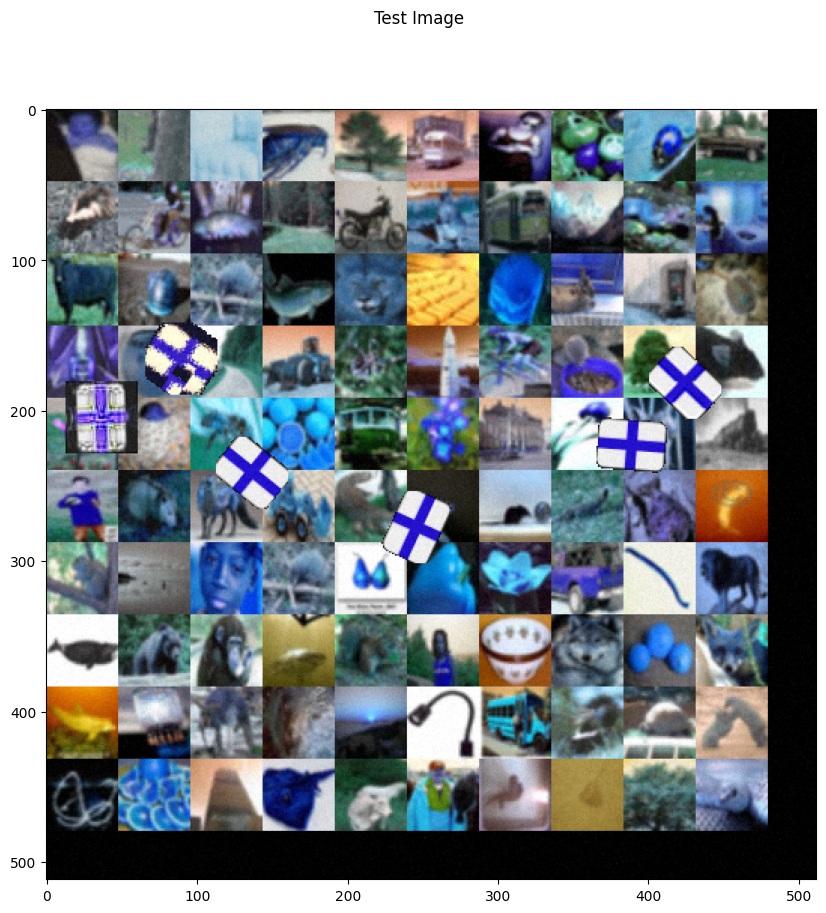

ground truths


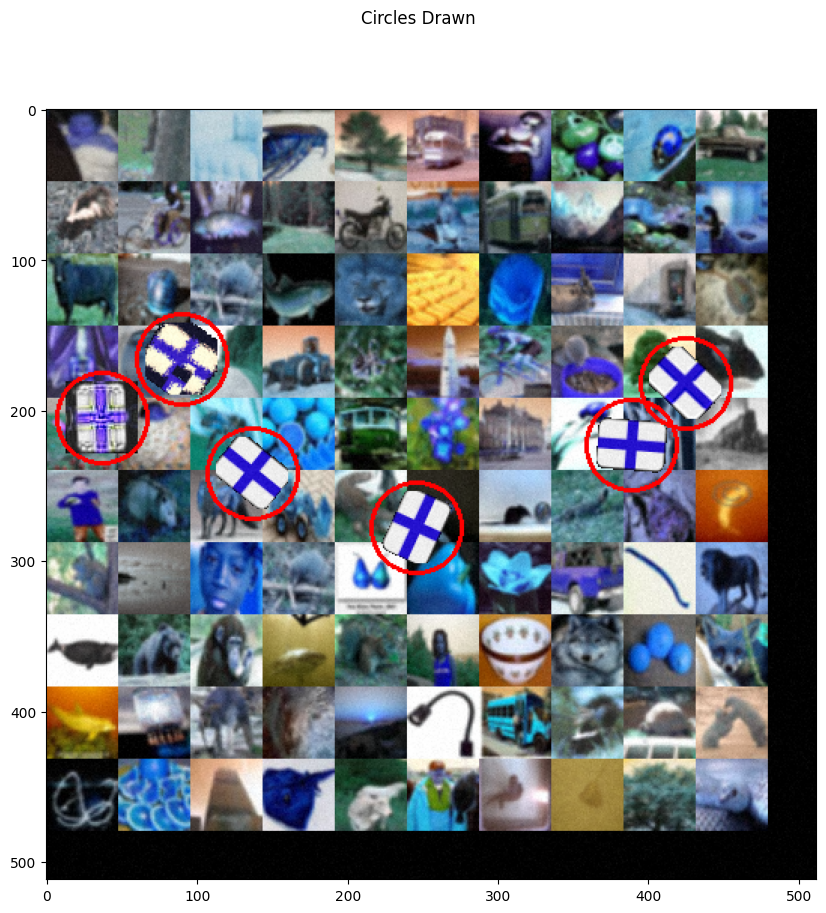

all SIFT kp's are [(254, 281), (254, 281), (95, 158), (95, 158), (21, 211), (478, 385), (424, 182), (424, 182), (423, 299), (251, 112), (37, 204), (25, 192), (246, 277), (415, 435), (424, 182), (409, 478)]
reduced kps


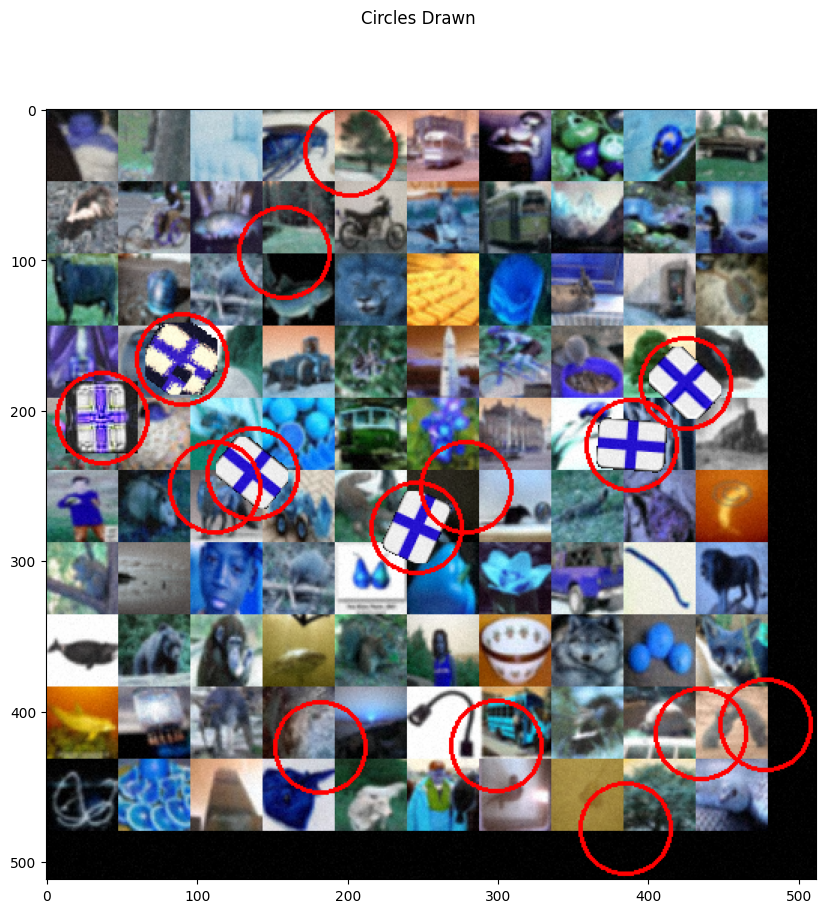

all kps


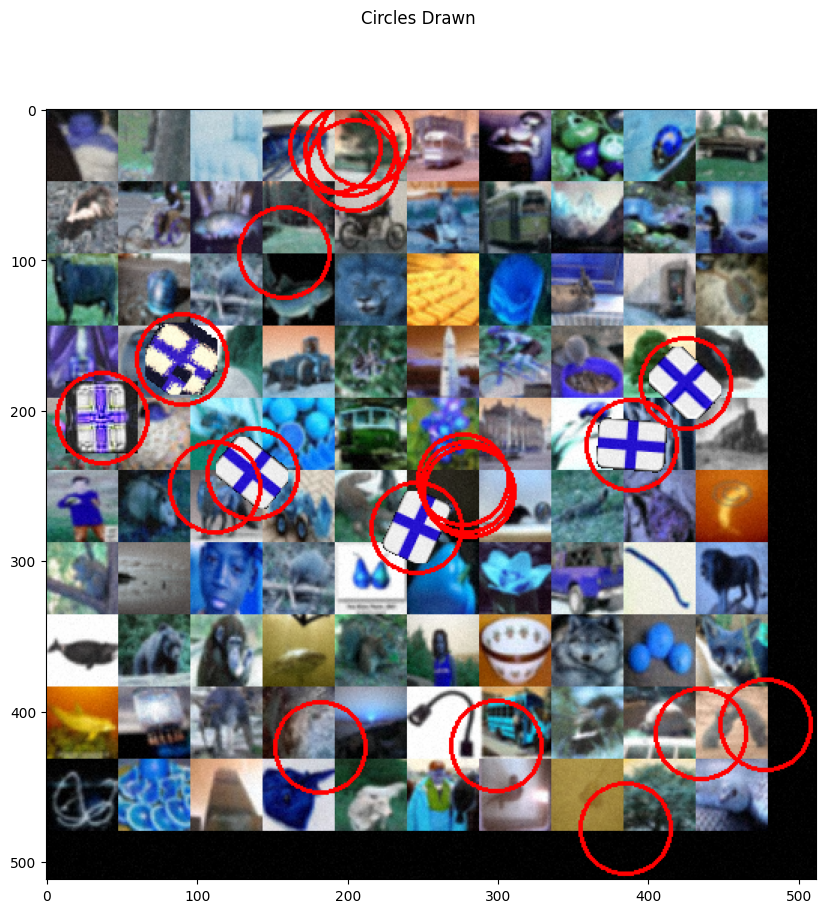

all SIFT kp's are [(254, 281), (254, 281), (95, 158), (95, 158), (21, 211), (478, 385), (424, 182), (424, 182), (423, 299), (251, 112), (37, 204), (25, 192), (246, 277), (415, 435), (424, 182), (409, 478)]
the reduced set of kp's are [(251, 279), (95, 158), (27, 202), (478, 385), (424, 182), (423, 299), (251, 112), (415, 435), (409, 478)]
the true kp's we want to match are [(223, 389), (278, 246), (166, 90), (182, 425), (205, 37), (242, 137)]
~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     Add
     Multiply
     Cutout
     CoarseDropout
     CoarseSaltAndPepper
     JpegCompression
     BlendAlpha
     BlendAlphaRegularGrid
     GaussianBlur
     MotionBlur
     MultiplyHueAndSaturation
     Grayscale
     ChangeColorTemperature
     SigmoidContrast
     CLAHE
     Emboss
     DirectedEdgeDetect
     Fliplr
     PiecewiseAffine
     PerspectiveTransform
     WithPolarWarping
     Rot90
     ElasticTransformation
     Jigsaw
Scores (lower is better)....
    Run 0 -> 309.0850678

In [ ]:
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

plt.figure(figsize = (10,10))
plt.suptitle('Test Image')
imgplot = plt.imshow(test_image,),plt.show()

# #plot denoised image
denoised_img = remove_noise(test_image)
if test_image.all() != denoised_img.all():
  plt.figure(figsize = (5,5))
  plt.suptitle('Denoised Image')
  imgplot = plt.imshow(denoised_img,),plt.show()

# #plot keypoints using SIFT
# sift_vanilla_demo(emoji_target,test_image,16) # view whats happening
# plt.suptitle('Original Image')
# imgplot = plt.imshow(test_image,),plt.show()

#plot adjusted image
adjusted_img = cv2.convertScaleAbs(denoised_img, alpha=0.23, beta=75)
# plt.figure(figsize = (5,5))
# plt.suptitle('Contrast and Brightness Adjusted Image')
# imgplot = plt.imshow(adjusted_img,),plt.show()

# plot GT's
print('ground truths')
draw_circles(test_image,gt_points)

#print all sift_keypoints
sift_predicted_full = sift_test_function(emoji_target, test_image,16)
print("all SIFT kp's are",sift_predicted_full)
sift_predicted = reduce_close_matches(sift_predicted_full,30)

#draw circles around matches
print('reduced kps')
draw_circles(test_image,sift_predicted)
print('all kps')
draw_circles(test_image, sift_predicted_full)
print("all SIFT kp's are",sift_predicted_full)
print("the reduced set of kp's are", sift_predicted)
print("the true kp's we want to match are", gt_points)

# test function to evaluate score
emoji_hunt_object.offical_test(test_function,emoji_hunt_object.get_config()) #run the test

# Licenses
* https://matplotlib.org/stable/users/project/license.html
* https://numpy.org/doc/stable/license.html
* https://github.com/opencv/opencv/blob/master/LICENSE
* https://www.json.org/license.html

                             